<a href="https://colab.research.google.com/github/MinYeongPark/AI_practice/blob/main/1_lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch # pytorch
import numpy as np # numpy
import matplotlib.pyplot as plt # matplotlib
import pandas as pd # pandas

In [ ]:
# cpu 사용할 것임
device = torch.device("cpu")

# MNIST 

In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(), # Tensor 형식으로 바꿔준다.
    transforms.Normalize((0.5), (1.0))
])

# train dataset, test dataset
train_dataset = MNIST(root='MNIST_data/', train=True, transform=mnist_transform, download=True)
test_dataset = MNIST(root='MNIST_data/', train=False, transform=mnist_transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [ ]:
train_dataset # 우리가 써먹을 수 있는 상태가 아님

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=1.0)
           )

In [ ]:
# DataLoader

batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # 배치사이즈 수만큼 끄집어 오는데 
                                                                                      # 1번부터 보여주는 게 아니라 이미지의 순서를 섞어서 128개를 뽑아올 것이다.
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)                                                                                      

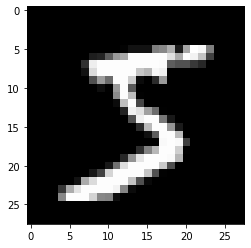

In [ ]:
img = train_dataset[0][0].numpy() # 0번째에 그림이 들어가 있음.
plt.imshow(img[0], cmap='gray')   # 흑백으로 출력

In [ ]:
img.shape # 1(채널 수 - RGB이면 3, 흑백이면 1) * 28*28

(1, 28, 28)

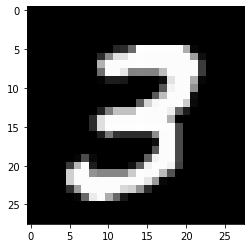

In [ ]:
img = train_dataset[7][0].numpy() # 7번째 그림 확인
plt.imshow(img[0], cmap='gray')   # 흑백으로 출력

# Fully connected 모델을 만들어보자

In [ ]:
from torch import nn

# nn.Sequantial (블록쌓기 같은 것)

mnist_fc_model = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(in_features=28*28*1, out_features=256),
    nn.Sigmoid(),
    nn.Linear(in_features=256, out_features=10), # 0 ~ 9 까지 분류하는거라 10으로 설정함.
    nn.Softmax()
)

In [ ]:
mnist_fc_model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=10, bias=True)
  (4): Softmax(dim=None)
)

In [ ]:
mnist_fc_model.to(device) # device = 'cpu'로 앞에서 설정했음.

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=10, bias=True)
  (4): Softmax(dim=None)
)

# device
train_dataset -> transforms.toTensor
<br> mnist_fc_model -> .to(device)

# 실제 학습이 일어나는 train을 만들 것

In [ ]:
from torch import optim

def train(model, epochs) :

    # optimizer 설정
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # loss function
    criterion = nn.CrossEntropyLoss() # classification 분류 

    for epoch in range(epochs) : 
        model.train() # model을 train상태로
        train_accuracy = 0.0

        for batch_ind, samples in enumerate(train_loader):
            x_t, y_t = samples # x는 입력, y는 출력(정답)
            # device로 x_t, y_t 보냄
            x_t, y_t = x_t.to(device), y_t.to(device)

            # x_t 넣어서 predicted
            pred = model(x_t)
            
            # predicted랑 y_t 비교
            # 둘의 차이 = loss 계산
            loss = criterion(pred, y_t)

            # loss 값을 가지고 back-propagation weight를 업데이트
            # optimizer가 해줍니다
            optimizer.zero_grad() # 초기화
            loss.backward()
            optimizer.step()

        # accuracy test form train dataset
        model.eval() # model을 평가상태로 만듦
        correct = 0
        for xx, yy in train_loader:
            data, target = xx.to(device), yy.to(device)
            pred = model(data) # pred [0, 0, 0.1, 0.2, 0.1 .. 0] 합이 1
            _, predicted = torch.max(pred, 1) # 높은 것 하나를 뽑아낸다
            correct += predicted.eq(target.data).sum()

        print("train accuracy : ", (100. * correct / len(train_loader.dataset)).item())

In [ ]:
train(mnist_fc_model, 10) # 점점 성능이 올라감.

train accuracy :  63.88833236694336
train accuracy :  66.1449966430664
train accuracy :  74.18333435058594
train accuracy :  75.06999969482422
train accuracy :  75.48833465576172
train accuracy :  75.71333312988281
train accuracy :  82.03666687011719
train accuracy :  82.61666870117188
train accuracy :  86.50666809082031
train accuracy :  90.51499938964844


In [ ]:
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

In [ ]:
get_n_params(mnist_fc_model) # 몇개의 파라미터가 있는지 확인

203530

# CNN 모델

In [ ]:
mnist_cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=0), # 첫번째 convolution # kernel_size는 몇*몇을 할지에 대한 것
    nn.ReLU(),
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    # CNN 끝

    nn.Flatten(),
    nn.Linear(in_features = 24*24*8, out_features = 48),
    nn.ReLU(),
    nn.Linear(in_features = 48, out_features = 10),
    nn.Softmax()
)

In [ ]:
get_n_params(mnist_cnn_model) # 2만 정도가 늘어남. -> 10% 정도 더 복잡해짐.

222058

In [ ]:
mnist_cnn_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=4608, out_features=48, bias=True)
  (6): ReLU()
  (7): Linear(in_features=48, out_features=10, bias=True)
  (8): Softmax(dim=None)
)

In [ ]:
mnist_cnn_model.to(device)
train(mnist_cnn_model, 10) # 성능이 아까보다는 좋게 나옴!

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train accuracy :  81.20166778564453
train accuracy :  83.61166381835938
train accuracy :  84.47666931152344
train accuracy :  85.12333679199219
train accuracy :  85.49333190917969
train accuracy :  85.88500213623047
train accuracy :  86.30333709716797
train accuracy :  86.34666442871094
train accuracy :  86.81999969482422
train accuracy :  86.97666931152344


# Le-Net 5

In [ ]:
import torch.nn.functional as F
lenet = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2),

    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2),

    nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1), # 1*1*120
    nn.Tanh(),

    nn.Flatten(),
    nn.Linear(in_features = 120, out_features = 84),
    nn.Tanh(),
    nn.Linear(in_features = 84, out_features = 10),
    nn.Softmax()
)

In [ ]:
get_n_params(lenet)

44426

In [ ]:
lenet.to(device)
train(lenet,10)
# 파라미터 수도 적고 성능도 더 좋다.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train accuracy :  81.37666320800781
train accuracy :  87.6933364868164
train accuracy :  89.84833526611328
train accuracy :  91.14666748046875
train accuracy :  92.28500366210938
train accuracy :  93.15833282470703
train accuracy :  93.75333404541016
train accuracy :  94.32666778564453
train accuracy :  94.82666778564453
train accuracy :  95.26166534423828
